In [169]:
# Import CVX and numpy libraries
import cvxpy as cvx
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

# Problem 1

Code to randomly generate the programming problems. The generate function randomly spawns anchor points, sensor locations as well as an adjacency matrix which enumerates which sensors are connected to which anchors/sensors

In [180]:
def generate(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)

    # Construct the anchor points
    a = np.random.rand(n+1,n)
    a = origA + np.multiply(a,rangA)

    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        #print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

The following code forces the sensors to be located within the convex hull of the anchors.

In [233]:
def generate_inside_hull(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)
    
    if(n == 1):
        a = np.array([-6., 6.])
    elif(n == 2):
        a = np.array([[-6., 15.], [-6., -15.], [8., 0.]])
    elif(n == 3):
        a = np.array([[-6., 15.,-10.], [-6., -15.,-10.], [8., 0., -10.], [0., 0., 10.]])
    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        #print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

## SOCP

Solve the SOCP problem with n dimensions and npoints sensors

In [259]:
def SOCP(n, npoints, convex, niters, printOut = False):
    #Generate the anchors, sensor locations and the corresponding adjacency matrix
    totalMSE = 0
    for k in range(niters):
        while True:
            try:
                if convex:
                    (a, p, adjacency) = generate(n, npoints)
                else:
                    (a, p, adjacency) = generate_inside_hull(n, npoints)

                # Compute the Euclidian distances to the anchor points
                adjSize = len(p) + len(a)
                asize = len(a)
                d = []

                #Retrieve the distances
                for i in range(adjSize):
                    for j in range(adjSize):
                        if(j > i and adjacency[i][j] > 0 and i < asize):
                            d.append((adjacency[i][j], j - asize, i, True))
                        elif(j > i and adjacency[i][j] > 0):
                            d.append((adjacency[i][j], i - asize, j - asize, False))

                # Construct the CVX variables to minimize
                x = [cvx.Variable(n) for i in range(len(p))]

                states = []
                constr = []

                #Construct the obj fcn as well as the constraints
                cost = cvx.norm(0)
                for (distance, i, j, truth) in d:
                    if(truth):
                        constr.append(cvx.norm(x[i] - a[j], 2) ** 2 <= distance ** 2)
                    else:
                        constr.append(cvx.norm(x[i] - x[j], 2) ** 2 <= distance ** 2)

                states.append(cvx.Problem(cvx.Minimize(cost), constr))

                # Add the states and solve the problem    
                prob = sum(states)
                prob.solve()
                
                if printOut:
                    print "Anchor points: ", a
                    
                MSE = 0
                if(n == 1): #Solves it more or less
                    for i, elem in enumerate(x):
                        soln1 = elem.value
                        point1 = p[i]
                        if printOut:
                            print("Sensor " + str(i) + " is at " + str(soln1) + " and the actual value is " + str(point1))
                        MSE += np.linalg.norm(soln1 - point1)
                elif(n == 2): #Can't solve this)
                    for i, elem in enumerate(x):
                        soln1 = elem.value.A.flatten()
                        soln1 = ['%.4f' % elem for elem in soln1]
                        soln1 = [float(elem) for elem in soln1]
                        point1 = ['%.4f' % elem for elem in p[i]]
                        point1 = [float(elem) for elem in point1]
                        if printOut:
                            print("Sensor " + str(i) + " is at " + str(soln1) + " and the actual value is " + str(point1))
                        MSE += np.linalg.norm(np.asarray(soln1) - np.asarray(point1))
                else:
                    for i, elem in enumerate(x):
                        soln1 = elem.value.A.flatten()
                        soln1 = ['%.4f' % elem for elem in soln1]
                        soln1 = [float(elem) for elem in soln1]
                        point1 = ['%.4f' % elem for elem in p[i]]
                        point1 = [float(elem) for elem in point1]
                        if printOut:
                            print("Sensor " + str(i) + " is at " + str(soln1) + " and the actual value is " + str(point1))
                        MSE += np.linalg.norm(np.asarray(soln1) - np.asarray(point1))
            except:
                continue
            break
    
        totalMSE += MSE
        if(n == 2 and printOut):
            G=nx.Graph()

            for i in range(n+1):
                G.add_node(i,pos=a[i])

            for i in range(npoints):
                G.add_node(n+1+i,pos=p[i])

            pos=nx.get_node_attributes(G,'pos')

            nx.draw_networkx_nodes(G,pos,
                                   nodelist=[i for i in range(n+1)],
                                   node_color='r',
                                   node_size=100,
                                   alpha=0.8,
                                   with_labels=True)
            nx.draw_networkx_nodes(G,pos,
                                   nodelist=[i for i in range(n+1,npoints+n+1)],
                                   node_color='b',
                                   node_size=100,
                                   alpha=0.8,
                                   with_labels=True)
            for i in range(npoints+n+1):
                for j in range(n+1,npoints+n+1):
                    if(adjacency[j,i] > 0.):
                        G.add_edge(i,j)

            nx.draw_networkx_edges(G, pos)
            nx.draw_networkx_labels(G, pos,font_color='w',font_size=8,font_weight='bold')
            plt.draw()  # pyplot draw()
        
    print "Average Mean Squared Error: ", totalMSE/niters

Anchor points:  [[ -6.  15.]
 [ -6. -15.]
 [  8.   0.]]
Sensor 0 is at [1.9086, -3.9435] and the actual value is [1.9086, -3.9435]
Sensor 1 is at [-2.1934, 3.8522] and the actual value is [-2.1934, 3.8522]
Sensor 2 is at [2.4398, 1.4045] and the actual value is [0.9104, 0.2217]
Sensor 3 is at [-3.7778, 1.2858] and the actual value is [-3.7778, 1.2858]
Sensor 4 is at [3.5373, -0.9787] and the actual value is [3.5373, -0.9787]
Sensor 5 is at [1.2341, -4.0889] and the actual value is [1.2341, -4.0889]
Sensor 6 is at [-0.7264, -3.5165] and the actual value is [-0.7264, -3.5165]
Sensor 7 is at [-0.476, 1.8734] and the actual value is [0.1194, 4.3085]
Sensor 8 is at [-4.9399, 3.7128] and the actual value is [-4.9399, 3.7128]
Sensor 9 is at [3.2777, -3.151] and the actual value is [3.2777, -3.151]
Average Mean Squared Error:  4.44024483961


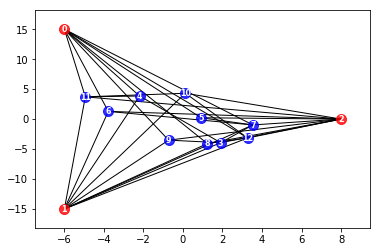

In [263]:
#Solve 2-D with 10 sensors inside the convex hull
SOCP(2, 10, False, 1, True)

In [256]:
#Solve 1-D with 10 sensors randomly generated
SOCP(1, 10, True, 100)

Average Mean Squared Error:  21.487840689


In [219]:
#Solve 1-D with 10 sensors inside the convex hull
SOCP(1, 10, False, 100)

Average Mean Squared Error:  5.63551647986


In [238]:
#Solve 2-D with 10 sensors outside the convex hull
SOCP(2, 10, True, 100)

Average Mean Squared Error:  34.4124995743


In [264]:
#Solve 2-D with 10 sensors inside the convex hull
SOCP(2, 10, False, 100)

Average Mean Squared Error:  11.5797159131


In [265]:
#Solve 3-D with 10 sensors outside the convex hull
SOCP(3, 10, True, 100)

Average Mean Squared Error:  45.7712716678


In [266]:
#Solve 3-D with 10 sensors inside the convex hull
SOCP(3, 10, False, 100)

Average Mean Squared Error:  39.241795095


## SDP

In [272]:
def SDP(n, npoints, convex, niter, printOut = False):
    totalMSE = 0
    for iteration in range(niter):
        if convex:
            (a, p, adjacency) = generate(n, npoints)
        else:
            (a, p, adjacency) = generate_inside_hull(n, npoints)

        # Compute the Euclidian distances to the anchor points
        adjSize = len(p) + len(a)
        asize = len(a)
        d = []

        #Retrieve the distances
        for i in range(adjSize):
            for j in range(adjSize):
                if(j > i and adjacency[i][j] > 0 and i < asize):
                    d.append((adjacency[i][j], j - asize, i, True))
                elif(j > i and adjacency[i][j] > 0):
                    d.append((adjacency[i][j], i - asize, j - asize, False))

        T = n + npoints

        # We are working in R^2

        #This creates a 3x3 semipositive definite matrix which we will 
        #use as part of our constraints
        z = cvx.Semidef(T)

        eyeConstraint = []
        anchorConstraints = []
        pointConstraints = []

        for i in range(n):
            temp = np.zeros((T,T))
            temp[i][i] = 1
            eyeConstraint.append(temp)

        temp = np.zeros((T,T))
        for i in range(n):
            for j in range(n):
                temp[i][j] = 1
        eyeConstraint.append(temp)

        for (distance, i, j, truth) in d:
            if truth:
                temp = np.zeros(npoints)
                temp[i] = -1.
                anchorConstraints.append((np.outer(np.append(a[j], temp), np.append(a[j], temp)), distance))
            else:
                tempi = np.zeros(npoints)
                tempj = np.zeros(npoints)
                tempi[i] = 1.
                tempj[j] = 1.
                temp = tempi - tempj
                corner = np.zeros(n)
                temp = np.append(corner, temp)
                pointConstraints.append((np.outer(temp,temp), distance))

        #Another empty states list
        states = []

        cost = cvx.norm(0)

        #The four constraints in the SDP relaxation problem
        #Note that the last constraint forces z to be SPD
        constr = []

        for i, mat in enumerate(eyeConstraint):
            if i < len(eyeConstraint) - 1:
                constr.append(cvx.sum_entries(cvx.mul_elemwise(mat, z)) == 1)
            else:
                constr.append(cvx.sum_entries(cvx.mul_elemwise(mat, z)) == n)

        for mat in anchorConstraints:
            constr.append(cvx.sum_entries(cvx.mul_elemwise(mat[0], z)) ==  mat[1] ** 2)

        for mat in pointConstraints:
            constr.append(cvx.sum_entries(cvx.mul_elemwise(mat[0], z)) ==  mat[1] ** 2)

        constr.append(z >> 0)

        #Add the constraints and cost function
        states.append(cvx.Problem(cvx.Minimize(cost), constr))

        #Solve the SDP relaxation problem
        prob = sum(states)
        prob.solve();    
    
        MSE = 0
        for i in range(npoints):
            soln1 = z.value.A[0:n, i + n]
            point1 = p[i]
            if printOut:
                print("Sensor " + str(i) + " is located at " + str(soln1) + " and the actual value is " + str(point1))
            MSE += np.linalg.norm(np.asarray(soln1) - np.asarray(point1))
    
    totalMSE += MSE
    
    print "Average MSE: ", totalMSE / niter

In [273]:
SDP(2, 10, True, 1, True)

Sensor 0 is located at [ 3.25509284 -0.26444447] and the actual value is [ 3.32138809 -0.47632316]
Sensor 1 is located at [-2.02078416  1.91881137] and the actual value is [-1.96399354  1.75122984]
Sensor 2 is located at [-3.06601674 -2.75182865] and the actual value is [-3.04625447 -2.90318264]
Sensor 3 is located at [ 0.40110708  1.87162496] and the actual value is [ 0.44866473  1.71001517]
Sensor 4 is located at [-3.0062092   3.41961073] and the actual value is [-2.96689915  3.2264451 ]
Sensor 5 is located at [ 3.76866992 -2.60891526] and the actual value is [ 3.8415688  -2.70548969]
Sensor 6 is located at [ 3.34519707 -1.82877565] and the actual value is [ 3.37748049 -1.93651421]
Sensor 7 is located at [-0.92668682 -1.72139949] and the actual value is [-0.88854049 -2.02918332]
Sensor 8 is located at [-0.13517114 -4.26892194] and the actual value is [-0.06062198 -4.28438901]
Sensor 9 is located at [ 3.35033897  4.41326433] and the actual value is [ 3.40466304  4.4483335 ]
Average MS

In [276]:
#Solve 1-D case with SDP with 10 sensors outside the convex hull
SDP(1, 10, True, 100, False)

Average MSE:  0.000578113207312


In [277]:
#Solve 1-D case with SDP with 10 sensors inside the convex hull
SDP(1, 10, False, 100, False)

Average MSE:  0.000232324758748


In [278]:
#Solve 2-D case with SDP with 10 sensors outside the convex hull
SDP(2, 10, True, 100, False)

Average MSE:  0.000486351126895


In [279]:
#Solve 2-D case with SDP with 10 sensors inside the convex hull
SDP(2, 10, False, 100, False)

Average MSE:  0.00127396659069


In [280]:
#Solve 3-D case with SDP with 10 sensors outside the convex hull
SDP(3, 10, True , 100, False)

Average MSE:  0.125906175648


In [281]:
#Solve 3-D case with SDP with 10 sensors inside the convex hull
SDP(3, 10, False, 100, False)

Average MSE:  0.0928766609074


## Unconstrained Optimization

In [167]:
# Note that the summations are unrolled for the ease of coding.
# The objective function is for the distances d11, d12, d22, d23, dhat12

# We update the objective function seen with two sensors and three anchors
def SNL(a, x, d):
    sum_obj = 0
    
    for (distance, i, j, truth) in d:
        if truth:
            sum_obj += ((np.linalg.norm(a[j] - x[i]) ** 2) - distance ** 2) ** 2
        else:
            sum_obj += (((np.linalg.norm(x[i] - x[j]) ** 2) - distance ** 2) ** 2)/2
    
    return sum_obj

# Here, we perform the gradient of the objective function
# Note that we keep the gradients for the two different
# sensors separate and stored in sum_x[0] and sum_x[1]
# respectively
def dSNL(a, x, d, npoints, n):
    sum_x = np.zeros((npoints, n))
    
    for (distance, i, j, truth) in d:
        if truth:
            sum_x[i] += 4 * (np.linalg.norm(a[j] - x[i]) ** 2 - distance ** 2) * (-a[j] + x[i])
        else:
            sum_x[i] += 4 * (np.linalg.norm(x[i] - x[j]) ** 2 - distance ** 2) * (x[i] - x[j])

    return sum_x

# Updated steepest descent where we perform it twice for the two
# different sensors
def steepest_descent_2(op, dop, a, xin, d, niter, npoints, n):
    x = np.copy(xin)
    
    for i in range(0, niter):
            direction = dop(a, x, d, npoints, n)
            
            alpha = 1.
            
            for j in range(npoints):
                while(op(a, x  - alpha * direction, d) > op(a, x, d) \
                      - 0.5 * alpha * np.dot(direction[j], direction[j])):
                        if alpha < 1e-9:
                            break
                        alpha *= 0.9

            x -= alpha * direction
    
    return x

In [285]:
import copy
def unconstrained(n, npoints, convex, niter, printOut):
    totalMSE = 0
    for iteration in range(niter):
        if convex:
            (a, p, adjacency) = generate(n, npoints)
        else:
            (a, p, adjacency) = generate_inside_hull(n, npoints)

        # Compute the Euclidian distances to the anchor points
        adjSize = len(p) + len(a)
        asize = len(a)
        d = []

        #Retrieve the distances
        for i in range(adjSize):
            for j in range(adjSize):
                if(j > i and adjacency[i][j] > 0 and i < asize):
                    d.append((adjacency[i][j], j - asize, i, True))
                elif(j > i and adjacency[i][j] > 0):
                    d.append((adjacency[i][j], i - asize, j - asize, False))

        x = [np.random.rand(n) for i in range(npoints)]

        d2 = copy.copy(d)

        for k in range(len(d)):
            (distance, i, j, truth) = d[k]

            if not truth:
                d2.append((distance, j, i, truth))

        soln = steepest_descent_2(SNL, dSNL, a, x, d2, 40, npoints, n)
        MSE = 0
        for i in range(npoints):
            if printOut:
                print("Sensor " + str(i) + " is located at " + str(soln[i]) + " and the actual value is " + str(p[i]))
            MSE += np.linalg.norm(np.asarray(soln[i]) - np.asarray(p[i]))
        totalMSE += MSE
    
    print "Average MSE: ", totalMSE / niter

In [286]:
unconstrained(2, 10, True, 1, True)

Sensor 0 is located at [-0.86812581  0.48407901] and the actual value is [-0.6857945  0.8084817]
Sensor 1 is located at [ 4.59278541 -1.70966744] and the actual value is [ 4.19080435 -2.41776976]
Sensor 2 is located at [-0.34701685  1.2598273 ] and the actual value is [-1.21676043 -0.0891005 ]
Sensor 3 is located at [-2.228097   -2.25051941] and the actual value is [ 0.71758964  3.38632808]
Sensor 4 is located at [ 0.48986389 -0.16950122] and the actual value is [ 0.32975014 -0.48928193]
Sensor 5 is located at [ 3.38572788 -3.54716483] and the actual value is [ 4.4659257  -2.07277988]
Sensor 6 is located at [ 0.54167122  3.70104951] and the actual value is [-3.36625585 -1.6605377 ]
Sensor 7 is located at [ 2.21414707  3.69819823] and the actual value is [-2.82593312 -3.23353678]
Sensor 8 is located at [ 4.86885904 -2.13103611] and the actual value is [ 4.96001561 -2.03486102]
Sensor 9 is located at [-1.278204    1.30435318] and the actual value is [-1.14144351  1.43928436]
Average MSE:

In [288]:
#Solve 1-D case with steepest descent with 10 sensors outside the convex hull
SDP(1, 10, True, 100)

Average MSE:  0.00105617407482


In [289]:
#Solve 1-D case with steepest descent with 10 sensors inside the convex hull
SDP(1, 10, False, 100)

Average MSE:  0.000370272918319


In [290]:
#Solve 2-D case with steepest descent with 10 sensors outside the convex hull
SDP(2, 10, True, 100)

Average MSE:  0.00026724813785


In [291]:
#Solve 2-D case with steepest descent with 10 sensors inside the convex hull
SDP(2, 10, False, 100)

Average MSE:  0.00236719315038


In [292]:
#Solve 3-D case with steepest descent with 10 sensors outside the convex hull
SDP(3, 10, True, 100)

Average MSE:  0.16111153046


In [294]:
#Solve 3-D case with steepest descent with 10 sensors inside the convex hull
SDP(3, 10, False, 100)

Average MSE:  0.165120322822
